In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import septum_mec.analysis.data_processing as dp
import expipe
import os
import pathlib
import math
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd

20:04:16 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (16,9)

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
def make_rate_map(x, y, t, sptr, a, at, binsize, smoothing, mask_zero_occupancy=False):
    from matplotlib import gridspec

    fig = plt.figure()
    gs = gridspec.GridSpec(1,4)
    axs = [fig.add_subplot(g, projection=p) for g, p in zip(gs, [None, None, None, 'polar'])]
    spatial_map = sp.SpatialMap(
        x, y, t, sptr, box_size=1.0, bin_size=binsize)
    
    rate_map = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    
    axs[0].imshow(rate_map, vmin=0)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('cluster id {}'.format(sptr.annotations['cluster_id']))
    
    axs[1].plot(x, y, 'k', alpha=0.3)
    # Remove spikes that fall outside the range of times.
    # Otherwise, interpolation will fail when plotting spikes in scatter plot.
    sptr = sptr[(sptr > min(t)) & (sptr < max(t))]
    
    x_spike = interp1d(t,x)(sptr)
    y_spike = interp1d(t,y)(sptr)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    axs[1].plot(x_spike, y_spike, 'o', color=(0.7, 0.2, 0.2))
    axs[1].set_ylim(1,0)
    axs[1].set_title('N spikes {}'.format(len(spike_times)))
    
    np.nan_to_num(rate_map, copy = False) # inplace
    autocorr = sp.tools.fftcorrelate2d(rate_map, rate_map, mode = 'full', normalize = True)
    axs[2].imshow(autocorr, vmin=0)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('gridness {:.2f}'.format(sp.gridcells.gridness(rate_map)))
    
    ang_bins, rate_ang = hd.head_direction_rate(sptr, a, at)
    hd_dir, hd_score = hd.head_direction_score(ang_bins, rate_ang)
    hd_dir = math.degrees(hd_dir)
    binsize = ang_bins[1] - ang_bins[0]
    axs[3].set_xticks([0, np.pi])
    axs[3].bar(ang_bins, rate_ang, width=binsize, color='b')
    axs[3].set_title('hd {:.2f}, {:.1f} deg'.format(hd_score, hd_dir))
    
    for ax in axs:
        ax.set_aspect(1)
        
def sort_by_cluster_id(spike_trains):
    if 'cluster_id' not in spike_trains[0].annotations:
        print('Unable to get cluster_id, save with phy to create')
    return sorted(spike_trains, key=lambda x: x.annotations['cluster_id'])

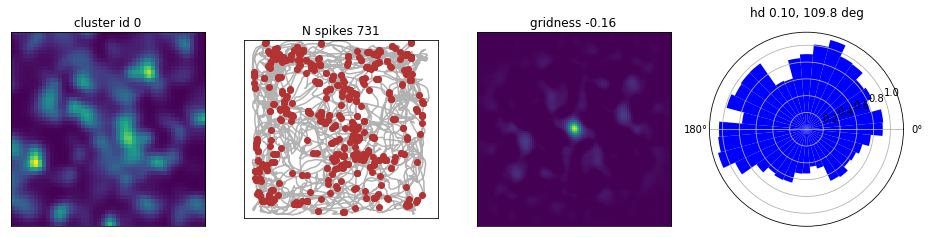

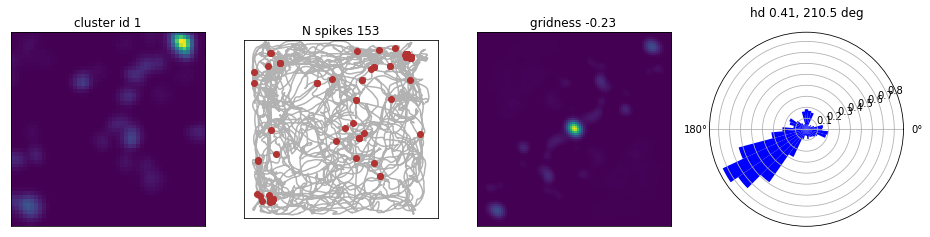

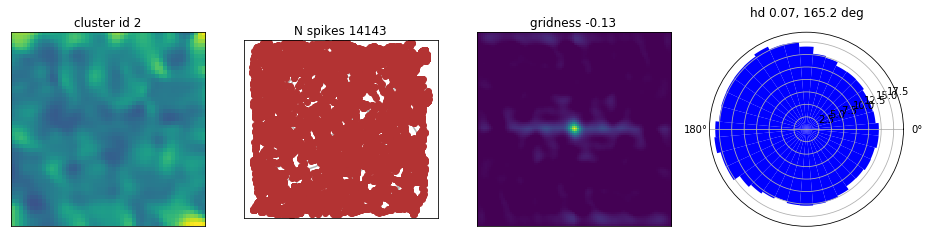

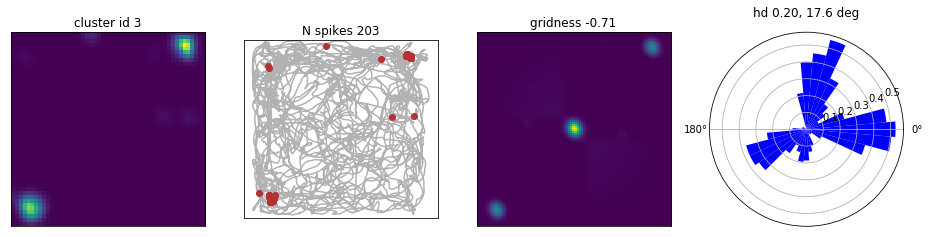

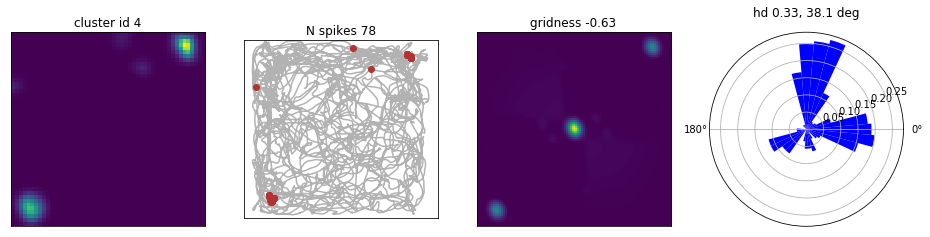

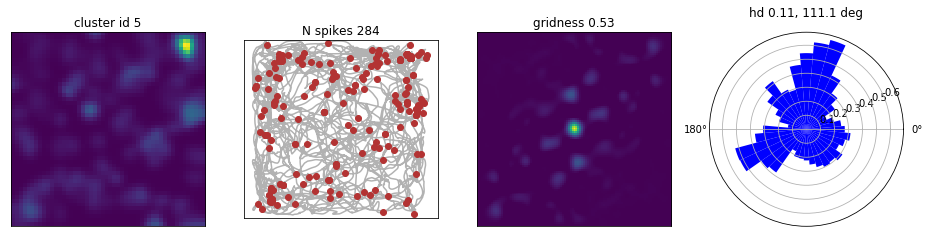

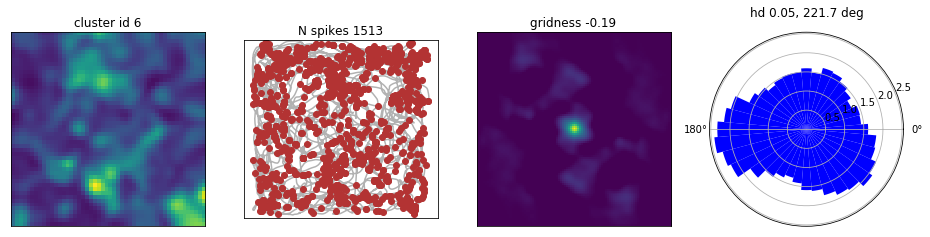

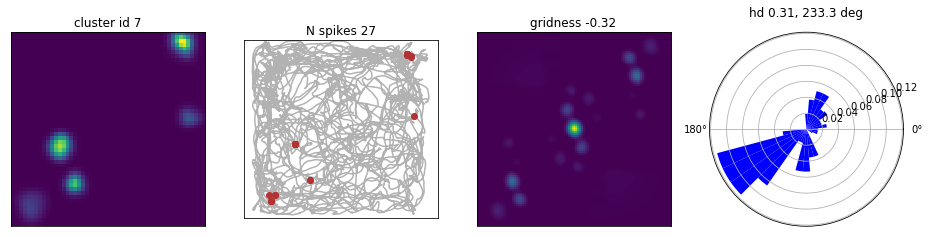

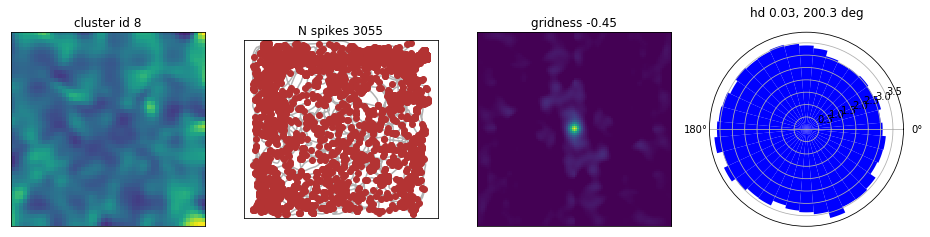

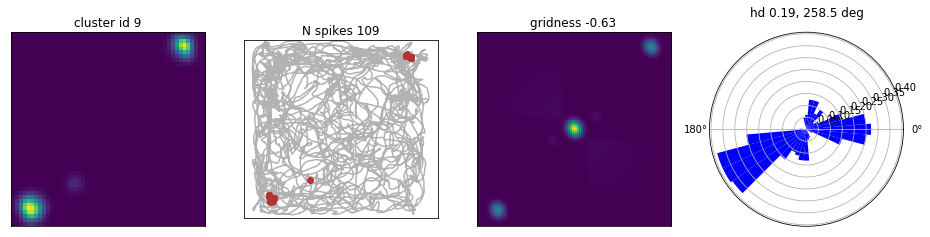

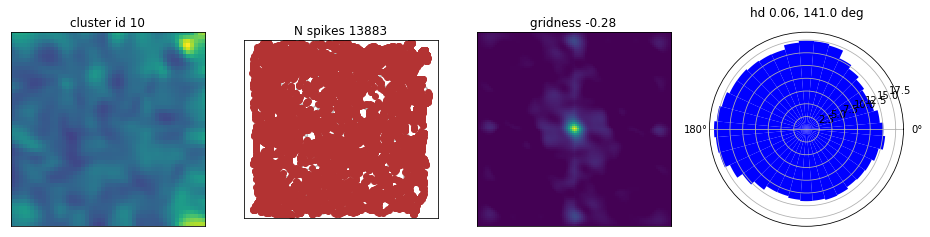

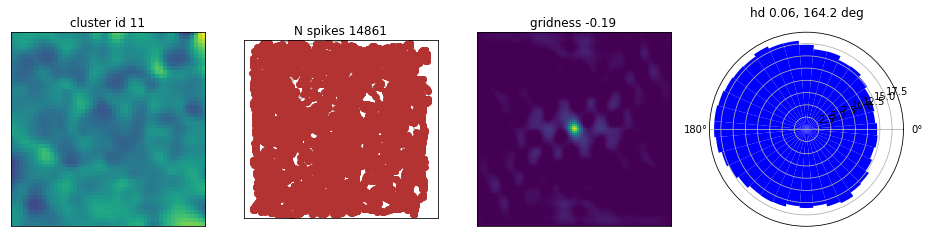

In [30]:
action_id = "1849-060319-4"
channel_id = 7
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

x, y, t, speed = dp.load_tracking(data_path, par)
a, at = dp.load_head_direction(data_path, par)
spike_trains = dp.load_spiketrains(data_path, channel_id)

if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

spike_trains = sort_by_cluster_id(spike_trains)
for spike_times in spike_trains:
    if t_start is not None and t_stop is not None:
        spike_mask = (spike_times < t_stop) & (spike_times > t_start)
        spike_times = spike_times[spike_mask]
        
    make_rate_map(
        x, y, t, spike_times, 
        a, at, 
        binsize, smoothing, mask_zero_occupancy=False)
    